# 2. Sparse GP approximation using inducing points

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.config import default_float
from gpflow.utilities import print_summary
import matplotlib.pyplot as plt
from utils import plot
import time

In the big data regime where we have millions of data points, a vanilla Gaussian process may not be a viable option for interpolating the data due to the large computational cost required to invert the matrix $k(\mathbf{X}, \mathbf{X{}}) + \sigma_{\text{obs}}^2 \mathbf{I}$. Recall that this inversion is necessary in the computation of the posterior, as well as the log marginal likelihood.

We look at an example below, where we have 2,000 data points extracted from a noisy sine function.

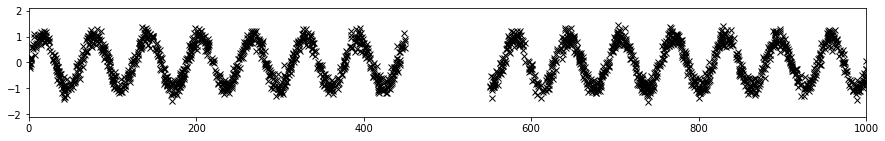

In [2]:
tf.random.set_seed(298923)

def noisy_sin(x, amplitude, lengthscale, noise_std):
    return amplitude*tf.math.sin(x/lengthscale) + noise_std * tf.random.normal(x.shape, dtype=default_float())


num_train_data, num_test_data = 1000, 5000

X1 = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 450
X2 = 550 + tf.random.uniform((num_train_data, 1), dtype=default_float()) * 450
X = tf.concat((X1, X2), axis=0)
X = tf.random.shuffle(X, seed=18783)

X_test = tf.linspace(0, 1000, num_test_data)[:, None]

noise_std = 0.2
amplitude = 1.
lengthscale = 10.
Y = noisy_sin(X, amplitude, lengthscale, noise_std)
Ytest = noisy_sin(X_test, amplitude, lengthscale, noise_std)

data = (X, Y)

plt.figure(figsize=(15,2))
plt.plot(X, Y, "xk")
plt.xlim((0, 1000))
plt.ylim((-2.1, 2.1))
plt.savefig("figs/long_sine_data.png", dpi=200)
plt.show()

We set up a vanilla GP below and time how long it takes to train and interpolate data. We use a periodic kernel this time, which has the functional form

\begin{align}
k(x, x') = \sigma^2 \exp\left(-\frac{2 \sin^2(\pi \|x - x'\|/p)}{l^2}\right),
\end{align}

where $\sigma^2$ is the amplitude, $l$ is the lengthscale and $p$ is the period. As the name suggests, this kernel constrains the learned functions to be periodic.


In [3]:
# Set up vanilla GP with periodic kernel
SquaredExponentialKernel = gpflow.kernels.SquaredExponential(lengthscales=1)
k = gpflow.kernels.Periodic(SquaredExponentialKernel, period=65)
gp = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
gp.likelihood.variance.assign(noise_std**2)
opt = gpflow.optimizers.Scipy()

In [4]:
# Time how long it takes to train a vanilla GP from 2000 data points
start = time.time()
opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))
done = time.time()
elapsed = done - start
print(f"time elapsed: {elapsed:.2f}s")
print_summary(gp)

2022-02-15 20:06:25.706132: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


time elapsed: 270.88s
╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 145.653     │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  12.0271    │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.period                   │ Parameter │ Softplus         │     

time elapsed: 6.78s


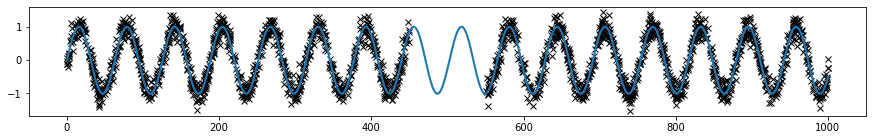

In [5]:
# Time how long it takes a vanilla GP to condition on data and make predictions on query points
start = time.time()
mean, var = gp.predict_f(X_test)
done = time.time()
elapsed = done - start
print(f"time elapsed: {elapsed:.2f}s")
plot(X_test, mean, var, data=data, figsize=(15,2))

## Scalable inference with sparse GPs

Sparse GPs is an umbrella term for methods that reduce the $\mathcal{O}(N^3)$ computational cost of GPs by employing a smaller number of data points to make predictions. A simple example of this would be to select a random subset of the training data to make predictions.
Here, we discuss a more sophisticated approach introduced in [Titsias (2009)](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf), which is based on approximating the posterior distribution using a small set of pseudo data and is typically considered the state-of-the-art sparse GP method.

Let $\mathbf{Z} = (z_1, \ldots, z_M)$ be $M$ points on the input space $X$ with $M << N$, which we call the *inducing points* and $\mathbf{u} = (f(z_1), \ldots, f(z_M))$ the *inducing variables* where $f$ is the Gaussian process. As before, we denote by $\mathbf{f}$ and $\mathbf{f}_*$, the Gaussian process evaluated at the training points $\mathbf{X}$ and test points $\mathbf{X}_*$ respectively.
Assuming that $\mathbf{f}$ and $\mathbf{f}_*$ are conditionally independent given $\mathbf{u}$, one can express the posterior $p(\mathbf{f}_* | \mathbf{y})$ in terms of the inducing variables as (see [Titsias (2009)](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf) for the derivation).
\begin{align*}
p(\mathbf{f}_* | \mathbf{y}) = \int p(\mathbf{f}_* | \mathbf{u}) \,p(\mathbf{u} | \mathbf{y}) \mathrm{d} \mathbf{u}.
\end{align*}

Since the variables $(\mathbf{f}_*, \mathbf{u})$ are jointly Gaussian, we have an explicit expression for $p(\mathbf{f}_* | \mathbf{u}) = \mathcal{N(\mathbf{f}_* | \mu_{*|u}, \Sigma_{*|u})}$ using the Gaussian conditioning formula.
\begin{align*}
\mu_{*|u} &= m(\mathbf{X}_*) - k(\mathbf{X}_*, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1}(\mathbf{u} - m(\mathbf{Z})), \\
\Sigma_{*|u} &= k(\mathbf{X}_*, \mathbf{X}_*) - k(\mathbf{X}_*, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1}k(\mathbf{Z}, \mathbf{X}_*).
\end{align*}

On the other hand, there is no explicit expression for $p(\mathbf{u} | \mathbf{y})$, so we just set it to be a Gaussian $p(\mathbf{u} | \mathbf{y}) \approx \phi(\mathbf{u}) = \mathcal{N}(\mathbf{u} | \mathbf{m}, \mathbf{S})$ where $\mathbf{m}, \mathbf{S}$ are free parameters (called the *variational parameters*, which also typically includes $\mathbf{Z}$) that are to be learned (more on this later). This yields the following approximation to the posterior:
\begin{align*}
q(\mathbf{f}_*) &= \int p(\mathbf{f}_* | \mathbf{u}) \,\phi(\mathbf{u}) \mathrm{d} \mathbf{u} = \mathcal{N}(\mu_*, \Sigma_*),
\end{align*}
where
\begin{align*}
\mu_* &= k(\mathbf{X}_*, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1} (\mathbf{m} - m(\mathbf{Z})), \\
\Sigma_* &= k(\mathbf{X}_*, \mathbf{X}_*) + k(\mathbf{X}_*, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1}\,[\mathbf{S} - k(\mathbf{Z}, \mathbf{Z})]\,k(\mathbf{Z}, \mathbf{Z})^{-1}k(\mathbf{Z}, \mathbf{X}_*),
\end{align*}
which produces the predictions at the $N_*$ query points $\mathbf{X}_*$. Note that since the cost of inverting the matrix $k(\mathbf{Z}, \mathbf{Z})$ is $\mathcal{O}(M^3)$ and the cost of performing the matrix multiplication $k(\mathbf{X}_*, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1}$ is $\mathcal{O}(N_*M^2)$, the total cost of computing the predictions in sparse GPs is $\mathcal{O}(M^3 + N_*M^2)$, a significant reduction from the $\mathcal{O}(N^3 + N_*N^2)$ cost for vanilla GPs.

We set up a sparse GP in `gpflow` as follows.

In [6]:
# Set up a sparse GP
M = 50  # Number of inducing locations

SquaredExponentialKernel = gpflow.kernels.SquaredExponential(lengthscales=1)
kernel = gpflow.kernels.Periodic(SquaredExponentialKernel, period=65)
Z = X[:M] # Initialize inducing point locations to the first M inputs in the dataset

gp_sparse = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=num_train_data)
gp_sparse.likelihood.variance.assign(noise_std**2)
print_summary(gp_sparse)

╒══════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤═════════════════════╕
│ name                                 │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value               │
╞══════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪═════════════════════╡
│ SVGP.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 1.0                 │
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼─────────────────────┤
│ SVGP.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 1.0                 │
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼─────────────────────┤
│ SVGP

Next, we look at how to actually learn the variational parameters $(\mathbf{m}, \mathbf{S}, \mathbf{Z})$ in our sparse GP so that our approximation $q(\mathbf{f}_*)$ is as "close" as possible to the true posterior $p(\mathbf{f}_* | \mathbf{y})$.
Here, we measure "closeness" of probability distributions using the Kullback-Leibler divergence:
\begin{align*}
\mathcal{KL}(q_{\mathbf{f}, \mathbf{u}}(\cdot) || p_{\mathbf{f}, \mathbf{u}}(\cdot | \mathbf{y})) &:= \iint q(\mathbf{f}, \mathbf{u}) \log \frac{q(\mathbf{f}, \mathbf{u})}{p(\mathbf{f}, \mathbf{u} | \mathbf{y})} \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} \\
&= ... = \underbrace{\log p(\mathbf{y})}_{\text{log marginal likelihood}} - \underbrace{\iint q(\mathbf{f}, \mathbf{u}) \log \frac{p(\mathbf{f}, \mathbf{u}, \mathbf{y})}{q(\mathbf{f}, \mathbf{u})} \mathrm{d} \mathbf{f} \mathrm{d} \mathbf{u}}_{=: \text{ELBO}}, \qquad \text{where} \quad q(\mathbf{f}, \mathbf{u}) := p(\mathbf{f} | \mathbf{u}) \phi(\mathbf{u}).
\end{align*}

The second term is often referred to as the *Evidence Lower Bound (ELBO)*, which has a closed-form expression in our setting (see Appendix). Since the first term does not depend on the variational parameters $(\mathbf{m}, \mathbf{S}, \mathbf{Z})$, we can minimise the KL divergence by maximising the ELBO with respect to $(\mathbf{m}, \mathbf{S}, \mathbf{Z})$. This can be achieved by taking stochastic gradient descent or its variants such as Adam, as explained in [Hensman et al. (2013)](https://arxiv.org/pdf/1309.6835.pdf).

Since the KL divergence is positive, the ELBO provides a lower bound for the log marginal likelihood (hence the name *Evidence Lower Bound*) as we can see from
\begin{align*}
\log p(\mathbf{y}) = \text{ELBO} - \mathcal{KL}(q_{\mathbf{f}, \mathbf{u}}(\cdot) || p_{\mathbf{f}, \mathbf{u}}(\cdot | \mathbf{y})) \geq \text{ELBO}.
\end{align*}
Therefore it is also possible to train the kernel hyperparameters by maximising the ELBO instead of the log marginal likelihood. These are usually optimised jointly with the variational parameters but sometimes it is beneficial to optimise them one after the other as demonstrated [here](https://gpflow.readthedocs.io/en/master/notebooks/advanced/natural_gradients.html).

Below, we follow the [GPflow documentation](https://gpflow.readthedocs.io/en/develop/notebooks/advanced/gps_for_big_data.html) to implement ELBO maximisation with respect to the variational parameters and kernel hyperparameters using the Adam optimizer.

ELBO at step 0: -19270.72
ELBO at step 100: -11853.31
ELBO at step 200: -9013.14
ELBO at step 300: -5545.58
ELBO at step 400: -4770.48
ELBO at step 500: -4156.02
ELBO at step 600: -3481.44
ELBO at step 700: -2728.12
ELBO at step 800: -2591.33
ELBO at step 900: -2552.41
ELBO at step 1000: -2082.76
ELBO at step 2000: -1570.08
ELBO at step 3000: -983.33
ELBO at step 4000: -776.27
ELBO at step 5000: -754.83
ELBO at step 6000: -511.88
ELBO at step 7000: -596.04
ELBO at step 8000: -412.05
ELBO at step 9000: -448.03
time elapsed: 51.75s


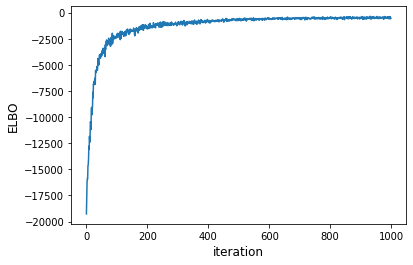

In [7]:
# Set minibatch size
minibatch_size = 100

# Set up tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(num_train_data)
train_iter = iter(train_dataset.batch(minibatch_size))

# Set up training loss (ELBO) and optimizer (Adam)
training_loss = gp_sparse.training_loss_closure(train_iter, compile=True)
optimizer = tf.optimizers.Adam()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, gp_sparse.trainable_variables)

# Iterate
elbo_log = []
iterations = 10000
start = time.time()
for step in range(iterations):
    optimization_step()
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        elbo_log.append(elbo)
    if step < 1000:
        if step % 100 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")
    else:
        if step % 1000 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")
done = time.time()
elapsed = done - start
print(f"time elapsed: {elapsed:.2f}s")

plt.plot(elbo_log)
plt.xlabel("iteration", fontsize=12)
plt.ylabel("ELBO", fontsize=12)
plt.show()

We see that training the sparse GP is much faster than training the full GP, although the results could vary depending on a number of factors such as the number of inducing points, minibatch size, number of iterations and initialisation. Often we must make a compromise between speed and accuracy.

Below, we time how long it takes to condition and predict using sparse GPs and plot our results.

time elapsed: 0.09s


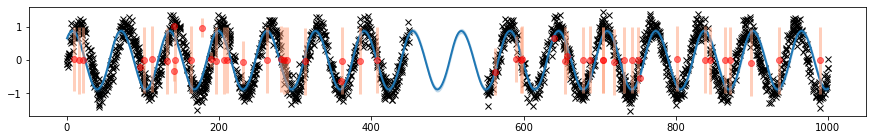

In [8]:
start = time.time()
sparse_mean, sparse_var = gp_sparse.predict_f(X_test)
done = time.time()
elapsed = done - start
print(f"time elapsed: {elapsed:.2f}s")
plot(X_test, sparse_mean, sparse_var, data=data, figsize=(15,2))
Z = gp_sparse.inducing_variable.Z.numpy()
mu = gp_sparse.q_mu.numpy()
S = np.diag(gp_sparse.q_sqrt.numpy()[0])
#plt.plot(Z, mu, "or")
plt.errorbar(Z[:, 0], mu[:, 0], yerr=S, fmt='o', color='r', ecolor='lightsalmon', elinewidth=3, capsize=0, alpha=0.5)
plt.show()


We see that inference using sparse GPs is much faster compared to the full GP and the results are near identical.

## Create animation for talk

In [9]:
from celluloid import Camera
from functools import partial

In [10]:
def take_picture(gp, X_query, data, fig, camera):
    mean, cov = gp.predict_f(X_query, full_cov=True)
    N, d = mean.shape
    var = tf.linalg.diag_part(cov)
    var = tf.reshape(var, (N, d))
    plot(X_query, mean, var, data=data, fig=fig)
    Z = gp.inducing_variable.Z.numpy()
    mu = gp.q_mu.numpy()
    S = np.diag(gp.q_sqrt.numpy()[0])
    plt.errorbar(Z[:, 0], mu[:, 0], yerr=S, fmt='o', color='r', ecolor='lightsalmon', elinewidth=3, capsize=0, alpha=0.5)
    plt.ylim((-2.1, 2.1))
    plt.xlim((0, 1000))
    camera.snap()

In [11]:
# Set up a sparse GP
M = 50  # Number of inducing locations

SquaredExponentialKernel = gpflow.kernels.SquaredExponential(lengthscales=1)
kernel = gpflow.kernels.Periodic(SquaredExponentialKernel, period=65)
Z = X[:M] # Initialize inducing point locations to the first M inputs in the dataset

gp_sparse = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=num_train_data)
gp_sparse.likelihood.variance.assign(noise_std**2)

# Set minibatch size
minibatch_size = 100

# Set up tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(num_train_data)
train_iter = iter(train_dataset.batch(minibatch_size))

# Set up training loss (ELBO) and optimizer (Adam)
training_loss = gp_sparse.training_loss_closure(train_iter, compile=True)
optimizer = tf.optimizers.Adam()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, gp_sparse.trainable_variables)

ELBO at step 0: -19368.83
ELBO at step 100: -12100.29
ELBO at step 200: -8507.47
ELBO at step 300: -5929.93
ELBO at step 400: -5098.66
ELBO at step 500: -4017.95
ELBO at step 600: -3366.98
ELBO at step 700: -2322.76
ELBO at step 800: -2569.33
ELBO at step 900: -2505.39
ELBO at step 1000: -2080.70
ELBO at step 2000: -1285.58
ELBO at step 3000: -1135.97
ELBO at step 4000: -716.56
ELBO at step 5000: -637.97
ELBO at step 6000: -498.89
ELBO at step 7000: -621.23
ELBO at step 8000: -543.45
ELBO at step 9000: -441.39
ELBO at step 10000: -533.57
ELBO at step 11000: -418.71


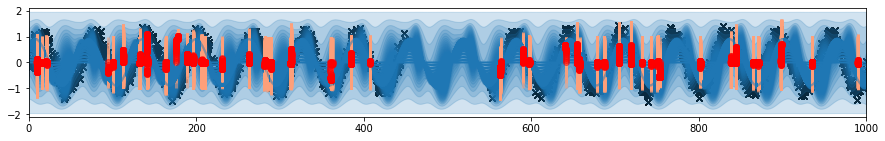

In [12]:
fig = plt.figure(figsize=(15, 2))
camera = Camera(fig)

snap = partial(take_picture, X_query=X_test, data=data, fig=fig, camera=camera)

iterations = 12000
for step in range(iterations):
    optimization_step()
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        elbo_log.append(elbo)
    if step < 1000:
        if step % 100 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")
    else:
        if step % 1000 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")

    if step % 100 == 0:
        snap(gp_sparse) # Take picture of the state at every 80 iterations for animating

# animation = camera.animate(interval=60, repeat=False)
# animation.save("figs/sparse_gp_conditioning.gif", dpi=200)

In [14]:
animation = camera.animate(interval=80, repeat=False)
animation.save("figs/sparse_gp_conditioning.gif", dpi=200)

MovieWriter ffmpeg unavailable; using Pillow instead.


## Appendix

### Closed-form expression of the ELBO in the Gaussian likelihood case
Let us first rewrite the ELBO as follows
\begin{align*}
\text{ELBO} &:= \iint q(\mathbf{f}, \mathbf{u}) \log \frac{p(\mathbf{f}, \mathbf{u}, \mathbf{y})}{q(\mathbf{f}, \mathbf{u})} \mathrm{d} \mathbf{f} \mathrm{d} \mathbf{u} \\
&= \iint q(\mathbf{f}, \mathbf{u}) \log \frac{p(\mathbf{y} | \mathbf{f}, \mathbf{u}) p(\mathbf{f}, \mathbf{u})}{q(\mathbf{f}, \mathbf{u})} \mathrm{d} \mathbf{f} \mathrm{d} \mathbf{u} \\
&= \iint q(\mathbf{f}, \mathbf{u}) \log p(\mathbf{y} | \mathbf{f}, \mathbf{u}) \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} - \iint q(\mathbf{f}, \mathbf{u}) \log \frac{q(\mathbf{f}, \mathbf{u})}{p(\mathbf{f}, \mathbf{u})} \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u}.
\end{align*}

#### The first term
Using the fact that $\mathbf{y}$ and $\mathbf{u}$ are conditionally independent given $\mathbf{f}$, and recalling that $q(\mathbf{f}, \mathbf{u}) := p(\mathbf{f} | \mathbf{u}) \phi(\mathbf{u})$, the first term simplifies to
\begin{align*}
\iint q(\mathbf{f}, \mathbf{u}) \log p(\mathbf{y} | \mathbf{f}, \mathbf{u}) \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} &= \iint p(\mathbf{f} | \mathbf{u}) \phi(\mathbf{u}) \log p(\mathbf{y} | \mathbf{f}) \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} \\
&= \int p(\mathbf{f} | \mathbf{u}) \underbrace{\int \phi(\mathbf{u}) \mathrm{d}\mathbf{u}}_{= 1} \log p(\mathbf{y} | \mathbf{f}) \mathrm{d}\mathbf{f} \\
&= \int p(\mathbf{f} | \mathbf{u}) \log p(\mathbf{y} | \mathbf{f}) \mathrm{d}\mathbf{f}.
\end{align*}

We assume that the likelihood $p(\mathbf{y} | \mathbf{f})$ is Gaussian and moreover separable, i.e.,
\begin{align*}
p(\mathbf{y} | \mathbf{f}) = \prod_{i=1}^N p(y_i | f_i) = \prod_{i=1}^N \mathcal{N}(y_i | f_i, \sigma_{\text{obs}}^2) = (2 \pi \sigma_{\text{obs}}^2)^{-N/2} \prod_{i=1}^N \exp\left(-\frac{(y_i - f_i)^2}{2 \sigma_{\text{obs}}^2}\right).
\end{align*}

Plugging this into the above expression, we have
\begin{align*}
\int p(\mathbf{f} | \mathbf{u}) \log p(\mathbf{y} | \mathbf{f}) \mathrm{d}\mathbf{f} &= \int \mathcal{N}(\mathbf{f} | \mu_{\mathbf{f}|\mathbf{u}}, \Sigma_{\mathbf{f}|\mathbf{u}}) \left[-\frac{N}{2} \log{2 \pi \sigma_{\text{obs}}^2} - \sum_{i=1}^N \frac{(y_i - f_i)^2}{2 \sigma_{\text{obs}}^2} \right] \mathrm{d}\mathbf{f} \\
&= -\frac{N}{2} \log{2 \pi \sigma_{\text{obs}}^2} - \frac{1}{2 \sigma_{\text{obs}}^2} \sum_{i=1}^N \underbrace{\int (y_i - f_i)^2 \mathcal{N}(\mathbf{f} | \mu_{\mathbf{f}|\mathbf{u}}, \Sigma_{\mathbf{f}|\mathbf{u}})}_{= \, (y_i - \mu^i_{\mathbf{f}|\mathbf{u}})^2 + \Sigma^{ii}_{\mathbf{f}|\mathbf{u}}} \mathrm{d} \mathbf{f} \\
&= -\frac{N}{2} \log{2 \pi \sigma_{\text{obs}}^2} - \frac{1}{2 \sigma_{\text{obs}}^2} \sum_{i=1}^N \left[(y_i - \mu^i_{\mathbf{f}|\mathbf{u}})^2 + \Sigma^{ii}_{\mathbf{f}|\mathbf{u}} \right],
\end{align*}
where
\begin{align*}
\mu_{\mathbf{f}|\mathbf{u}}^i &= m(x_i) - k(x_i, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1}(\mathbf{u} - m(\mathbf{Z})), \\
\Sigma_{\mathbf{f}|\mathbf{u}}^{ii} &= k(x_i, x_i) - k(x_i, \mathbf{Z}) \,k(\mathbf{Z}, \mathbf{Z})^{-1}k(\mathbf{Z}, x_i).
\end{align*}

#### The second term
Using the relations $q(\mathbf{f}, \mathbf{u}) := p(\mathbf{f} | \mathbf{u}) \phi(\mathbf{u})$ and $p(\mathbf{f}, \mathbf{u}) := p(\mathbf{f} | \mathbf{u}) p(\mathbf{u})$, we have
\begin{align*}
\iint q(\mathbf{f}, \mathbf{u}) \log \frac{q(\mathbf{f}, \mathbf{u})}{p(\mathbf{f}, \mathbf{u})} \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} &= \iint p(\mathbf{f} | \mathbf{u}) \phi(\mathbf{u}) \log \frac{\cancel{p(\mathbf{f} | \mathbf{u})} \phi(\mathbf{u})}{\cancel{p(\mathbf{f} | \mathbf{u})} p(\mathbf{u})} \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} \\
&= \iint p(\mathbf{f} | \mathbf{u}) \phi(\mathbf{u}) \log \frac{\phi(\mathbf{u})}{p(\mathbf{u})} \mathrm{d}\mathbf{f} \mathrm{d}\mathbf{u} \\
&= \int \underbrace{\int p(\mathbf{f} | \mathbf{u}) \mathrm{d}\mathbf{f}}_{= 1} \phi(\mathbf{u}) \log \frac{\phi(\mathbf{u})}{p(\mathbf{u})} \mathrm{d}\mathbf{u} \\
&= \int \phi(\mathbf{u}) \log \frac{\phi(\mathbf{u})}{p(\mathbf{u})} \mathrm{d}\mathbf{u} \\
&=: \mathcal{KL}(\phi_{\mathbf{u}}(\cdot) || p_{\mathbf{u}}(\cdot)).
\end{align*}

Since $\phi(\mathbf{u})$ and $p(\mathbf{u})$ are both Gaussian, an explicit formula for the KL divergence is available:
\begin{align*}
\mathcal{KL}(\phi_{\mathbf{u}}(\cdot) || p_{\mathbf{u}}(\cdot)) = \frac12 \left[\log \frac{|\det k(\mathbf{Z}, \mathbf{Z})|}{|\det \mathbf{S}|} - M + \text{tr}\left(k(\mathbf{Z}, \mathbf{Z})^{-1}\mathbf{S}\right) + (\mathbf{m} - m(\mathbf{Z})) \,k(\mathbf{Z}, \mathbf{Z})^{-1} (\mathbf{m} - m(\mathbf{Z}))^T \right].
\end{align*}

#### Computational complexity of evaluating the ELBO
In the first term, the bulk of the time is spent inverting the matrix $k(\mathbf{Z}, \mathbf{Z})$ and performing a $M \times M$ matrix-vector multiplication at every iteration over the training data, resulting in the total cost of $\mathcal{O}(M^3 + NM^2)$. We can however reduce this cost by minibatching the training data as explained in [Hensman et al. (2013)](https://arxiv.org/pdf/1309.6835.pdf) to get a Monte Carlo estimate of the ELBO, which results in the total cost of $\mathcal{O}(M^3 + BM^2)$, where $B$ is the minibatch size.

In the second term, most of the time is spent taking determinants and inverses of $M \times M$ matrices, as well as performing the matrix-matrix multiplication $k(\mathbf{Z}, \mathbf{Z})^{-1}\mathbf{S}$, all of which cost $\mathcal{O}(M^3)$ time.

Thus, the total cost of computing the ELBO exactly is $\mathcal{O}(M^3 + NM^2)$ and the cost of estimating via minibatches is $\mathcal{O}(M^3 + BM^2)$.